In [ ]:
This code for the CURE clustering was taken from the:

https://colab.research.google.com/github/Makstarr/CURE-algorithm/blob/main/CURE.ipynb

## <center> Imports </center>

In [14]:
import sys
import itertools 
import numpy as np
import pandas as pd

# Needed for plotting
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

# Needed for generating classification, regression and clustering datasets
import sklearn.datasets as dt
from sklearn.datasets import make_moons

# Needed for generating data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

import seaborn as sns
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# <center> CURE </center>

In [15]:
class Cluster(object):
    COUNTER = 0
    # Создание кластера на основе точек, их индексов и входных параметров
    def __init__(self, points, p_ids, rep_count, alpha):
        # Счетчик числа кластеров
        Cluster.COUNTER += 1
        self.id = Cluster.COUNTER
        # Добавление точе в формате массива
        self.points = np.array(points) if type(points) == type([]) else points
        # Число точек и число измерений
        self.n_points, self.dimensions = self.points.shape
        # Индексы точек
        self.p_ids = p_ids
        # Среднее значение по кластеру 
        self.mean = None
        # Параметры алгоритма
        self.alpha = alpha
        self.rep_count = rep_count
        # Считает точки-представители
        self.reps = self.assignReps()
        # Переменная ближайшего кластера
        self.closest = None
        # Переменная дистанции до ближайшего кластера
        self.closestDist = sys.maxsize

    #  Расчет центроида
    def getMean(self):
        # Если он уже посчитан возвращает значение
        if self.mean is not None:
            return self.mean
        # Если нет считает как сумма координат точек/число точек
        self.mean = self.points.sum(axis=0)/(self.n_points*1.0)
        return self.mean

    # Считает точки-представители
    def assignReps(self):
        # Если точек в кластере меньше чем точек-представителей
        # То все они и есть представители
        if self.n_points <= self.rep_count:
            return self.points[:,:]
        # Пустой сет и пустой массив
        tmp_set = set()
        reps = []
        # Для всех точек представителей
        for i in range(self.rep_count):
            max_dist = 0
            # Для всех точек в кластере (ищем самые далекие точки)
            for j in range(self.n_points):
                # Если точек представителей 0
                if i == 0:
                    # Расстояние между точкой и центроидом
                    min_dist = Cluster.p_distance(self.points[j], self.getMean())
                # Если точек представителей > 0
                else:
                    # Поиск минимального расстояния между точкой и массивом точек-представителей
                    min_dist = self.getClosestDist(self.points[j], reps)
                # Если расстояние больше максимального, новое максимальное
                if min_dist >= max_dist:
                    # максимальное расстояние
                    max_dist = min_dist
                    # индекс найденной точки 
                    max_point = j
            # если этой точки нет в списке
            if max_point not in tmp_set:
                # добавить
                tmp_set.add(max_point)
                # если есть массив представителей
                if reps is not None:
                    # Находим точку по индексу
                    point = self.points[max_point]
                    # Добавляем представителя сдвинутого на Alpha в сторону центроида 
                    reps.append(point + self.alpha * (self.getMean() - point))

                # если нет массива представителей
                else:
                    # Добавляем представителя сдвинутого на Alpha в сторону центроида 
                    point = self.points[max_point]
                    reps = [point + self.alpha * (self.getMean() - point)]
        # Возвращаем точки представители
        reps = np.array(reps)
        return reps
            
    # Поиск минимального расстояния между точкой и массивом точек
    def getClosestDist(self, point, points):
        points = np.array(points)
        k=np.empty(points.shape[0])
        for j in range(points.shape[0]):
            k[j]+=sum(((points[j]-point)**2)**0.5)

        return min(k)

    def __str__(self):
        return "[ID:%d] PointCount=%d, ClosestDist=%0.2f with [ID:%d]"%(self.id, self.n_points, self.closestDist, self.closest.id if self.closest else -1)
    
    def __repr(self):
        return self.__str__()
    
    @classmethod
    # Создаем новый кластер из двух соседей 
    def merge(cls, cluster1, cluster2):
        # Проверка что оба кластера в одном измерении
        if cluster1.dimensions != cluster2.dimensions:
            raise ValueError('Ошибка! Измерения точек не совпадают!')
        # Обьединяем точки кластеров в общий массив с сохранением
        combined_points = np.concatenate((cluster1.points, cluster2.points))
        # Обьединяем индексы точек кластеров в общий массив (Они не np.array поэтому просто +)
        combined_p_ids = cluster1.p_ids + cluster2.p_ids
        # Создаем новенький кластер
        new_cluster = Cluster(combined_points, combined_p_ids, cluster1.rep_count, cluster1.alpha)
        # Присваиваем ему среднее значение по кластеру
        new_cluster.mean = (cluster1.getMean()*cluster1.n_points + cluster2.getMean()*cluster2.n_points)/(new_cluster.n_points*1.0)
        return new_cluster
    
    # Минимальное растояние от точки до кластера
    def pointToClusterDistance(self, point):
        min_dist = sys.maxsize
        # Для всех точек-представителей
        for rep_index in range(len(self.reps)):
            # Вычисляется расстояние между точкой и точкой представителем
            dist = Cluster.p_distance(self.reps[rep_index], point)
            # Поиск минимального
            min_dist = min(min_dist, dist)
        return min_dist
    
    @staticmethod
    # Вычисляется расстояние между точкой и точкой представителем
    def p_distance(point1, point2):
        i=0
        for j in range(len(point1)):
            i+=((point1[j]-point2[j])**2)**0.5
        return ((1-(6*i**2)/lenght_data*(lenght_data**2-1))**2)**0.5

    @staticmethod
    # Расчет дистанции между текущим кластером и другим кластером
    def c_distance(cluster1, cluster2):
        min_dist = sys.maxsize
        # Для всех точек-представителей одного
        for rep_1_index in range(len(cluster1.reps)):
            # Для всех точек-представителей другого
            for rep_2_index in range(len(cluster2.reps)):
                #  Вычисляется расстояние между точками представителями
                dist = Cluster.p_distance(cluster1.reps[rep_1_index], cluster2.reps[rep_2_index])
                #  Берется минимальная
                min_dist = min(min_dist, dist)
        return min_dist

In [16]:
# Иерархическая кластеризация
class HeirarchicalClustering(object):
    # Создание обьекта метода, на основе входных параметров
    def __init__(self, cluster_count, rep_count, alpha):
        self.cluster_count = cluster_count
        self.clusters = []
        self.rep_count = rep_count
        self.alpha = alpha
    #
    #
    # №1 ПЕРВНОНАЧАЛЬНАЯ КЛАСТЕРИЗАЦИЯ НА ОСНОВЕ МАЛЕНЬКОЙ ВЫБОРКИ
    #
    #
    def fit(self, points):
        # Присвоение точкам индексов и создание кластеров для каждой из точек
        for p_index, point in enumerate(points):
            self.clusters.append(Cluster([point], [p_index], self.rep_count, self.alpha))
        
        # Определение ближайших кластеров
        for index in range(len(self.clusters)):
            self.assignClosestCluster(self.clusters[index])
          
        # Пока число кластеров больше заданного при запуске алгоритма
        while len(self.clusters) > self.cluster_count:

            # Найти индекс кластера, который можно обьединить с соседом
            u_index = self.getMergeCandidate()
            # Убрать кластер из массива кластеров и привоить переменной 
            # и привоить переменной u-кластер
            u_cluster = self.clusters.pop(u_index)
            # v-кластер равен соседу убранного
            v_cluster = u_cluster.closest
            # Найти ближайший и убрать его из массива
            self.removeCluster(v_cluster)
            # Создаем новый кластер из двух соседей (метод класса Cluster)
            new_cluster = Cluster.merge(u_cluster, v_cluster)
            # Пересчет связей в списке кластеров
            self.rebuildClosestClusterLinks(new_cluster, u_cluster.id, v_cluster.id)
            # Добавляем новый кластер в список
            self.clusters.append(new_cluster)

    # Определение ближайших кластеров
    def assignClosestCluster(self, cluster):
        # задание минимальной дистанции в ввиде очень большого int
        min_dist = sys.maxsize
        # переменная для ближайшего кластера
        closest = None
        # Для всех кластеров
        for i in range(len(self.clusters)):
            # Если индекс кластера тот же самый что и у текущего (уже обьедденины) ничего не делай
            if cluster.id == self.clusters[i].id: continue
            # Расчет дистанции между текущим кластером и кластером для которого вызвана функция (метод кластера)
            dist = Cluster.c_distance(cluster, self.clusters[i])
            # Если дистанция меньше минимальной (изначально огромного числа), значит это новая минимальная дистанция     
            if dist < min_dist:
                min_dist = dist
                # Значит текущий кластер самый близкий к тому, для которого вызвана функция
                closest = self.clusters[i]
        # Присваиваем найденный ближайший кластер тому, для которого вызвана функция
        cluster.closest = closest
        # Присваиваем дистанцию между ними
        cluster.closestDist = min_dist

    # Найти подходящие для обьединения кластеры
    def getMergeCandidate(self):
        # задание минимальной дистанции в ввиде очень большого int
        min_dist = sys.maxsize
        # Индекс подходящего для обьединения кластера
        cluster_index = 0
        # Для всех кластеров
        for i in range(len(self.clusters)):
            # Берем найденную на предыдущем шаге дистанцию до ближайшего кластера
            dist = self.clusters[i].closestDist
            # Ели дистанция меньше минимальной (изначально большое число)
            if dist < min_dist:
              # Новая минимальная дистанция между кластерами
              min_dist = dist
              cluster_index = i
        # Возвращаем айди кластера, который может быть объединен с соседом
        return cluster_index

    # Найти и убрать кластер из массива
    def removeCluster(self, cluster):
        # Для всех кластеров
        for i in range(len(self.clusters)):
            # Находим кластер в списке
            if self.clusters[i].id == cluster.id:
                # Убираем кластер из списка
                self.clusters[i] = self.clusters[-1]
                self.clusters.pop()
                return
        return "Кластер не был найден в списке"

    # Пересчет связей в списке кластеров
    def rebuildClosestClusterLinks(self, new_cluster, u_cluster_id, v_cluster_id):
        min_dist = sys.maxsize
        # Для всех кластеров
        for i in range(len(self.clusters)):
            # Дистанция между новым и текущим
            new_dist = Cluster.c_distance(new_cluster, self.clusters[i])
            # Если найденная дистанция меньше самой близкой
            # Обьявляем кластер ближайшим соседом нового
            if new_cluster.closestDist > new_dist:
                new_cluster.closestDist = new_dist
                new_cluster.closest = self.clusters[i]
            # Если ближайший кластер текущего был одним из обьединенных
            if self.clusters[i].closest.id in (u_cluster_id, v_cluster_id):
                # Если этот кластер ближе чем новая минималная дистанция
                # Присваиваем ему новый ближайший
                if self.clusters[i].closestDist < new_dist:
                    self.assignClosestCluster(self.clusters[i])
                # Есои нет
                # То самый ближайший к нему новый, обьединенный
                else:
                    self.clusters[i].closestDist = new_dist
                    self.clusters[i].closest = new_cluster
            # Если не был
            else:
              # Если его ближайший сосед дальше чем новый кластер
              # То самый ближайший к нему новый, обьединенный
                if self.clusters[i].closestDist > new_dist:
                    self.clusters[i].closestDist = new_dist
                    self.clusters[i].closest = new_cluster
   
    #
    #
    # №2 КЛАСТЕРИЗАЦИЯ НА ОСНОВЕ ВСЕЙ ВЫБОРКИ
    #
    #
    def predict(self, points):
        points = np.array(points)
        # Новый словарь, с пустым массивом, для каждого кластера 
        predictions = {cluster.id:[] for cluster in self.clusters}
        # Для всех точек в массиве
        for i in range(len(points)):
            # Подбираем к какому классу пренадлежит точка 
            label = self.predict_point(points[i])
            # Присваиваем в словарь, в массив одного из классов
            predictions[label].append(i)
        # Возвращаем массивы индексов точек распределенные по классам
        return predictions.values()

    #  Подбираем к какому классу пренадлежит точка 
    def predict_point(self, point):
        point = np.array(point)
        min_dist = sys.maxsize
        label = None
        # Для всех кластеров
        for i in range(len(self.clusters)):
            # Минимальное растояние от точки до кластера (Метод кластера)
            dist = self.clusters[i].pointToClusterDistance(point)
            # Если дистанция меньше чем минимальная, тогда относим к соответсвующему кластеру
            if dist < min_dist:
                min_dist = dist
                label = self.clusters[i].id
        # Возвращаем индекс кластера
        return label

In [17]:
def readDataset(data_file, columns, country):
    # создаем датафрэйм пандас с выбранными столбцами
    countries = pd.read_csv(data_file, usecols = country)
    data_frame = pd.read_csv(data_file, usecols = columns)
    data_frame.head(2)
    # создаем np массив с выбранными столбцами
    data_array = data_frame.to_numpy()
    data_frame = pd.DataFrame(data=data_array, columns=["Общая оценка","ВВП на душу населения","Социальная поддержка","Продолжительность жизни","Свобода","Щедрость","Оценка коррупции"])
    return data_frame, data_array, countries

## <center> Syntetic data modeling </center>

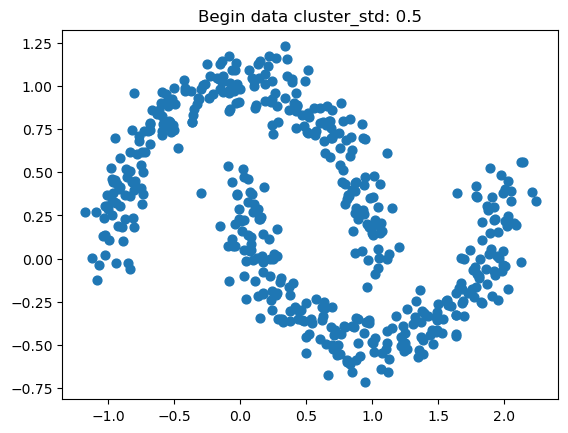

In [18]:
cluster_count = 2
rep_count = 19
alpha = 0.5

# Моделирование синтетических данных
# x, label = dt.make_blobs(n_features=2, centers=cluster_count, cluster_std=0.5, random_state=rand_state)
x, label = make_moons(n_samples = 500, noise = 0.1, random_state=rand_state)
# Построение графика данных
my_scatter_plot = plt.scatter(x[:,0], x[:,1], s=40, vmin=min(label), vmax=max(label), cmap=color_map_discrete)
plt.title('Begin data cluster_std: '+str(0.5))
# Кол-во объектов
lenght_data = len(x)

## <center> Selection count of clusters </center>

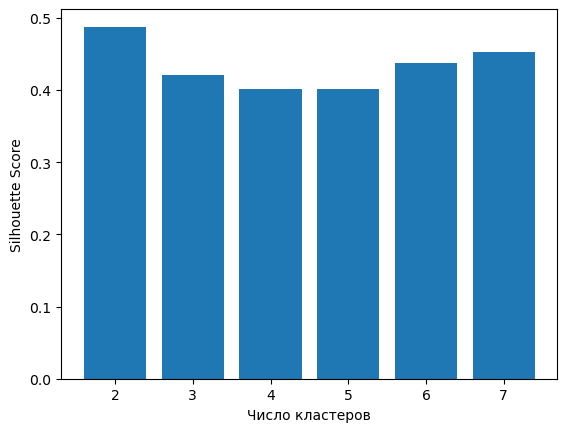

In [19]:
silhouette_scores = [] 
for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(x, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(x))) 

k = [2, 3, 4, 5, 6, 7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Число кластеров', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

## <center> CURE clustering </center>

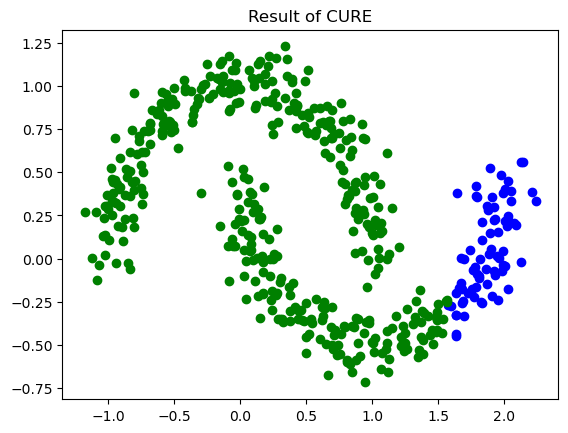

In [21]:
# Создание кластеризатора
hc = HeirarchicalClustering(cluster_count, rep_count, alpha)
# ПЕРВНОНАЧАЛЬНАЯ КЛАСТЕРИЗАЦИЯ НА ОСНОВЕ МАЛЕНЬКОЙ ВЫБОРКИ
hc.fit(x)
# КЛАСТЕРИЗАЦИЯ НА ОСНОВЕ ВСЕЙ ВЫБОРКИ
predictions = hc.predict(x)
# Красим точки в соответствии с предсказаниями
for cluster, color in zip(predictions, ['b', 'g', 'r', 'y']):
    for j in cluster:
        plt.scatter(x[j][0], x[j][1], c=color)
plt.title('Result of CURE')
plt.show()